# CNN Regression Model

In [158]:
import pandas as pd
from Data_preparation_Library import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import choice
from scipy import signal
from pickle import load,dump
import math
from sklearn.preprocessing import QuantileTransformer
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import backend as K
from pickle import dump, load

## Sample

<AxesSubplot:title={'center':'Velocity'}>

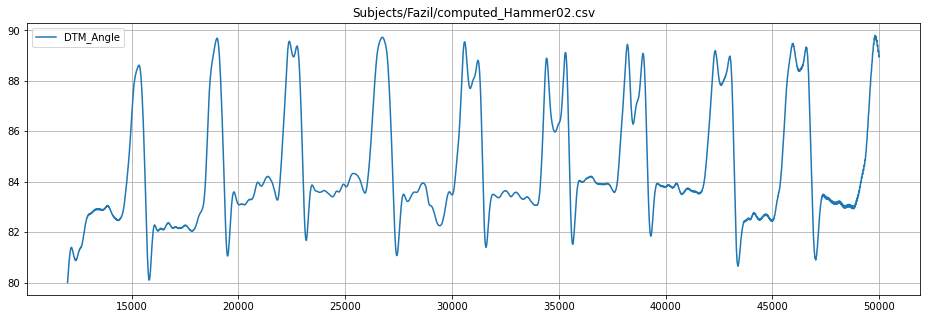

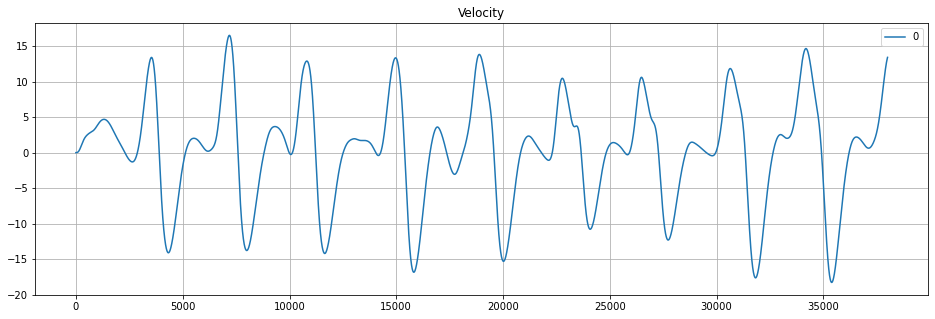

In [98]:
file = 'Subjects/Fazil/computed_Hammer02.csv'
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
angle_lables = ['DTM_Angle'] # 'Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle'
df = pd.read_csv(file,index_col=0)[12000:50000]#[32000:40000]
df[angle_lables].plot(figsize=(16,5),title=file,grid=True)

arr = np.diff([df['DTM_Angle'].values[0]]+list(df['DTM_Angle']))
arr = arr/(1/2000)
b,a = signal.butter(3, 1,fs=2000)
arr = signal.lfilter(b, a,arr)
pd.DataFrame(arr).plot(figsize=(16,5),title='Velocity',grid=True)

In [159]:
def quantile_normalize(y,save=False):
    if save == True:
        qt = QuantileTransformer(n_quantiles=1000, random_state=0)
        qt.fit(y.reshape(1,-1))
        dump(qt, open('qt_norm_dtm.pkl', 'wb'))
    qt = load(open('qt_norm_dtm.pkl', 'rb'))
    return yq

## Prep Data

In [160]:
window = 250

In [85]:
files = []
subjects = ['Fazil','Nikhil','Ingy','Abhishek','Jai', 'Deepti', 'Nirmayee', 'Varun'] #'Fazil/day_04_14_21' ,'Varun'
# subjects = ['Fazil'] #'Fazil/day_04_14_21' ,'Varun'
for subj in subjects:
    path = 'Subjects/'+subj
    trial_names = ['Hammer','Cup'] # 'Bulb','Hammer' ,'Cup','Screw'
#     trial_names = ['Bulb','Screw','Hammer' ,'Cup',] #
    for exp in trial_names:
        for i in range(3):
            if(i==0):
                files.append(path+'/computed_'+exp+'.csv')
            else:
                files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
files

['Subjects/Fazil/computed_Hammer.csv',
 'Subjects/Fazil/computed_Hammer01.csv',
 'Subjects/Fazil/computed_Hammer02.csv',
 'Subjects/Fazil/computed_Cup.csv',
 'Subjects/Fazil/computed_Cup01.csv',
 'Subjects/Fazil/computed_Cup02.csv']

In [86]:
files_df = []
for file in files:
    files_df.append(pd.read_csv(file,index_col=0))#[12000:50000])

In [87]:
files_df = filter_df(files_df)

### Remove Test Reps Data

In [47]:
test_rep_files = ['Subjects/Fazil/computed_Hammer02.csv', 
                  'Subjects/Fazil/computed_Cup02.csv']
tr_range = [32000,40000]

In [48]:
files_df = []
for file in files:
    if file in test_rep_files:
        df = pd.read_csv(file,index_col=0)[12000:50000]
        df = df.drop(df.index[tr_range[0]:tr_range[1]])
    else:
        df = pd.read_csv(file,index_col=0)[12000:50000]
    files_df.append(df)
files_df = filter_df(files_df)

### Only Removed Reps

In [41]:
files_df = []
files = test_rep_files
for file in files:
    df = pd.read_csv(file,index_col=0)
    files_df.append(df[tr_range[0]:tr_range[1]])
files_df = filter_df(files_df)

F:\The Stuffs\Awear\Final_Project\wrist_data_collection_AWEAR\Data_preparation_Library.py:467: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  files_df[i][emg_labels] = np.array(emg_df)
C:\Users\moham\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


## Rearrange

In [88]:
from collections import deque
rearr_labels = []
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
labels = deque(emg_labels)
labels.rotate(1)
rearr_labels.append(list(labels))
labels.rotate(-2)
rearr_labels.append(list(labels))
rearr_labels

[['EMG8', 'EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7'],
 ['EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8', 'EMG1']]

In [89]:
files_df_rearrange = []
for df in tqdm(files_df):
    for lb in rearr_labels:
        df[emg_labels] = df[lb]
        files_df_rearrange.append(df) 
    
files_df = files_df+files_df_rearrange
len(files_df)

18

## Generate Training Data

In [90]:
X, y = multiple_prep_data_velocity(files_df,window,interval=10,Normalize=True,rms=False,angle_label ='DTM_Angle')
X.shape

(96750, 250, 8)

## Time Window Normalize

In [31]:
X_mean = np.zeros(X[0].shape)
for x in X:
    X_mean = X_mean + x
X_mean = X_mean/X.shape[0]
X_std = np.sqrt(variance(X))
np.save('mean_std',np.array([X_mean,X_std]))

In [32]:
X_mean = np.load('mean_std_master.npy')[0]
X_std = np.load('mean_std_master.npy')[1]

In [33]:
X_new = []
for x in tqdm(X):
    X_new.append((x-X_mean)/X_std)
X = np.array(X_new)

## Test Train Split

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

(77400, 250, 8)
(19350, 250, 8)
(77400, 1)
(19350, 1)


In [23]:
np.save('prepared_data/X_train',X_train)
np.save('prepared_data/X_test',X_test)
np.save('prepared_data/y_train',y_train)
np.save('prepared_data/y_test',y_test)

In [103]:
X_train = np.load('prepared_data/X_train.npy')
X_test = np.load('prepared_data/X_test.npy')
y_train = np.load('prepared_data/y_train.npy')
y_test = np.load('prepared_data/y_test.npy')

In [104]:
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

(377640, 250, 8)
(94410, 250, 8)
(377640, 1)
(94410, 1)


# Neural Network Regression

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
n_outputs = 1

In [106]:
n_outputs = 1
filter_size = 11
in_shape = (X_train.shape[1],X_train.shape[2])

model = Sequential()

model.add(Conv1D(filters=512, kernel_size=filter_size, activation='relu', input_shape=in_shape))
model.add(Conv1D(filters=512, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=512, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=512, kernel_size=filter_size, activation='relu'))

model.add(Dropout(0.5))

model.add(Conv1D(filters=512, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=512, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=512, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=512, kernel_size=filter_size, activation='relu'))



model.add(Conv1D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=filter_size, activation='relu'))

# model.add(Dropout(0.5))

model.add(Conv1D(filters=16, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=16, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=16, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=16, kernel_size=filter_size, activation='relu'))

model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))
# model.add(Dense(8,activation='relu'))

model.add(Dense(n_outputs,activation='linear'))

# model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer='adam',metrics=[])

checkpoint_filepath = 'best_model_reg.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_100 (Conv1D)          (None, 240, 512)          45568     
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 230, 512)          2884096   
_________________________________________________________________
conv1d_102 (Conv1D)          (None, 220, 512)          2884096   
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 210, 512)          2884096   
_________________________________________________________________
dropout_12 (Dropout)         (None, 210, 512)          0         
_________________________________________________________________
conv1d_104 (Conv1D)          (None, 200, 512)          2884096   
_________________________________________________________________
conv1d_105 (Conv1D)          (None, 190, 512)        

In [107]:
cnn_history=model.fit(X_train,y_train,epochs = 10,batch_size = 128,validation_data = (X_test,y_test),callbacks=[test_loss(X,y),model_checkpoint_callback])#test_loss(X,y),

Epoch 1/10
   6/2951 [..............................] - ETA: 23:38 - loss: nan

2021-07-28 01:53:32,659 [Geometry3D WARNING] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0943s vs `on_train_batch_end` time: 0.3256s). Check your callbacks.


  23/2951 [..............................] - ETA: 23:39 - loss: nan

KeyboardInterrupt: 

In [ ]:
best_model = load_model('best_model_reg.hdf5')
best_model.save('models/dtm_velocity_model_{}.hdf5'.format(250))

In [15]:
cnn_history_df = pd.DataFrame(cnn_history.history) 
hist_csv_file = 'regression_history.csv'
with open(hist_csv_file, mode='w') as f:
    cnn_history_df.to_csv(f)

NameError: name 'cnn_history' is not defined

In [17]:
cnn_history_df = pd.read_csv('regression_history.csv')

<AxesSubplot:>

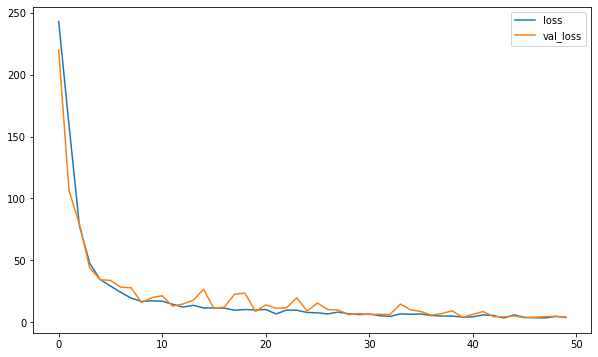

In [18]:
cnn_history_df[['loss', 'val_loss']].plot(figsize=(10,6))

<AxesSubplot:>

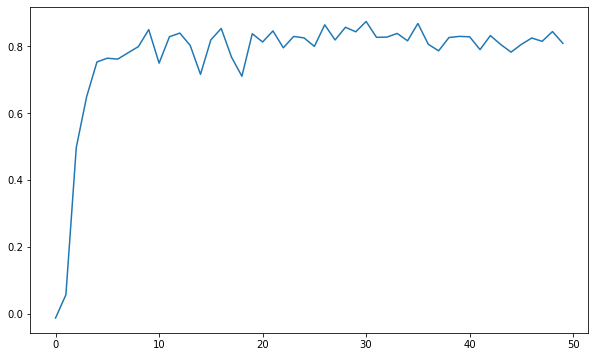

In [20]:
cnn_history_df['Pearson_r'].plot(figsize=(10,6))

## Model Testing

In [31]:
window = 250
best_model = load_model('models/prosup_velocity_model_{}_p86.hdf5'.format(window))
# best_model = load_model('best_model_reg.hdf5')

In [108]:
file = 'Subjects/Fazil/computed_Hammer02.csv'
df = pd.read_csv(file,index_col=0)[32000:40000]
df = filter_df([df])[0]

In [109]:
X, y = prep_data_velocity(df,window,interval=10,Normalize=True,rms=False,angle_label ='DTM_Angle')

In [70]:
file = 'Subjects/Fazil/computed_Hammer02.csv'
df = pd.read_csv(file,index_col=0)[32000:40000]
df = filter_df([df])[0]
X2, y2 = prep_data_velocity(df,window,interval=10,Normalize=True,rms=False,angle_label ='DTM_Angle')

In [71]:
X = np.vstack((X,X2))
y = np.hstack((y,y2)).reshape((len(y)+len(y2),1))
print(X.shape,y.shape)

(1550, 250, 8) (1550, 1)


In [87]:
X_mean = np.load('mean_std_master.npy')[0]
X_std = np.load('mean_std_master.npy')[1]
X_new = []
for x in tqdm(X):
    X_new.append((x-X_mean)/X_std)
X = np.array(X_new)

25/25 [==============================] - 0s 6ms/step - loss: 52.5601


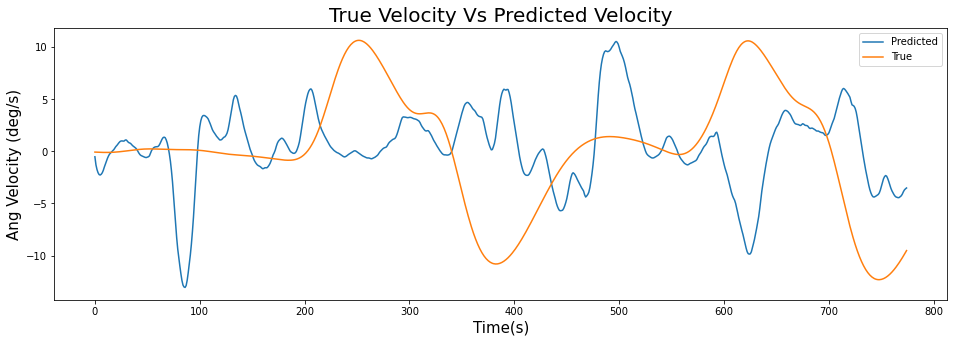

In [34]:
test_model = best_model
pred = test_model.predict(X)
test_model.evaluate(X,y)

plt.figure(figsize=(16,5))
pred = filter_array(pred,order=1,cf=50,fs=2000)
# y = filter_array(y,order=1,cf=100,fs=2000)
plt.plot(pred)
plt.plot(y)
plt.title('True Velocity Vs Predicted Velocity',size=20)
plt.ylabel('Ang Velocity (deg/s)',size=15)
plt.xlabel('Time(s)', size=15)
plt.legend(['Predicted', 'True'], loc='best')
plt.show()

In [13]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
print('MSE Loss -',mean_squared_error(y,pred))
print('RMSE -',mean_squared_error(y,pred,squared=False))
print('Pearson Correlation Coefficient -',pearsonr(y.flatten(),pred.flatten()))

MSE Loss - 26.586180203459417
RMSE - 5.156178837420151
Pearson Correlation Coefficient - (0.8170755998489332, 4.579530339918226e-187)


In [ ]:
# pearsonr 0.8

In [12]:
def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(xm * ym)
    r_den = K.sum(K.sum(K.square(xm)) * K.sum(K.square(ym)))
    r = r_num / r_den
    return 1 - r**2


def correlation_coefficient(y_true, y_pred):
    pearson_r, update_op = tf.contrib.metrics.streaming_pearson_correlation(y_pred, y_true)
    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'correlation_coefficient' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        pearson_r = tf.identity(pearson_r)
        return 1-pearson_r**2
def pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)

In [57]:
system_sleep()

In [ ]:
system_shutdown()

In [11]:
class test_loss(tf.keras.callbacks.Callback):

    def __init__(self, X,y):
        super(test_loss, self).__init__()
        self.X_t = X
        self.y_t = y
        
    def on_epoch_end(self, epoch, logs={}):
        logs['Pearson_r'] = float('-inf')
        pred = self.model.predict(self.X_t)
        score = pearsonr(pred.flatten(),self.y_t.flatten())[0]
        logs['Pearson_r'] = np.round(score, 5)
        print('Pearson_r_Test= ',np.round(score, 5))

